In [30]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt

from typing import Callable, Dict, Tuple, List

np.set_printoptions(precision=4)

In [2]:
%load_ext autoreload
%autoreload 2

### Data Prep

In [8]:
from sklearn.datasets import load_boston
boston = load_boston()

data = boston.data
target = boston.target
features = boston.feature_names

In [9]:
print(data.shape, target.shape)

(506, 13) (506,)


In [20]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

### Manual Linear Regression

In [27]:
def forward_pass(X_batch: ndarray,
                y_batch: ndarray,
                weights: Dict[str, ndarray]
                ) -> Tuple[float, Dict[str, ndarray]]:
    
    #generate predictions and calculate loss
    
    #assert batch sizes of X and Y are equal
    assert X_batch.shape[0] == y_batch.shape[0]
    #assert shape matching criteria for matmul
    assert X_batch.shape[1] == weights['W'].shape[0]
    #assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    #forward pass
    N = np.dot(X_batch, weights['W'])
    P = N + weights['B']
    loss = np.mean(np.power(y_batch - P, 2))
    
    #saving information computed on forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch
    
    return forward_info, loss

In [12]:
def permute_data(X: ndarray, y:ndarray):
    #permute  X and y using the same permutation along axis=0
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [25]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    
    '''
    compute dLdW and dLdB for the step-by-step linear regression model
    '''
    batch_size = forward_info['X'].shape[0]
    
    dLdP = -2 * (forward_info['y'] - forward_info['P'])
    
    dPdN = np.ones_like(forward_info['N'])
    
    dPdB = np.ones_like(weights['B'])
    
    dLdN = dLdP * dPdN
    
    dNdW = np.transpose(forward_info['X'], (1,0))
    
    #applying matmul for dLdW, with dNdW on the left
    dLdW = np.dot(dNdW, dLdN)
    
    #need to sum along dim representing the batch size
    dLdB = (dLdP * dPdB).sum(axis=0)
    
    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB
    
    return loss_gradients

In [15]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray,
                  y: ndarray,
                  start: int = 0,
                  batch_size: int = 10) -> Batch:
    #Generate batch from X and y, given a start position
    
    assert X.ndim == y.ndim == 2
    #X and Y must be 2-dim
    
    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
        
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [23]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    
    #initialize weights on first forward pass of model
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1,1)
    
    weights['W'] = W
    weights['B'] = B
    
    return weights

In [18]:
def train(X: ndarray,
          y: ndarray,
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False,
          return_weights: bool = False,
          seed: int = 1) -> None:
        
        #train a model for certain number of epochs
        
        if seed:
            np.random.seed(seed)
        start = 0
        
        # initialize weights
        weights = init_weights(X.shape[1])
        
        #permute data
        X, y = permute_data(X,y)
        
        if return_losses:
            losses = []
            
        for i in range(n_iter):
            
            #generate batch
            if start >= X.shape[0]:
                X, y = permute_data(X, y)
                start = 0
        
            X_batch, y_batch = generate_batch(X, y, start, batch_size)
            start += batch_size
            
            forward_info, loss = forward_pass(X_batch, y_batch, weights)
            
            if return_losses:
                losses.append(loss)
                
            loss_grads = loss_gradients(forward_info, weights)
            for key in weights.keys():
                weights[key] -= learning_rate * loss_grads[key]
        
        if return_weights:
            return losses, weights
        
        return None


In [99]:
train_info = train(X_train, y_train,
                  n_iter = 1000,
                  learning_rate = 0.001,
                  batch_size = 23,
                  return_losses=True,
                  return_weights=True,
                  seed=3101)

losses = train_info[0]
weights = train_info[1]

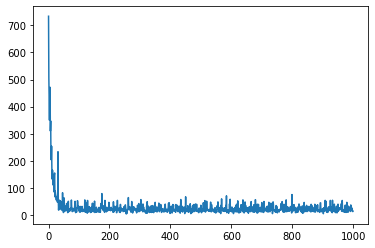

In [100]:
plt.plot(list(range(1000)), losses)

In [101]:
def predict(X: ndarray,
           weights: Dict[str, ndarray]):
    
    #generate predictions
    
    N = np.dot(X, weights['W'])
    
    return N + weights['B']

In [102]:
preds = predict(X_test, weights)

In [103]:
#model errors

def mae(preds: ndarray, actuals: ndarray):
    #compute mean absolute error
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    #compute root mean squared error
    return np.sqrt(np.mean(np.power(preds-actuals, 2)))

In [104]:
print(f'mean absolute error : {round(mae(preds, y_test), 4)}')
print(f'root mean squared error : {round(rmse(preds, y_test)/y_test.mean(), 4)}')

mean absolute error : 3.556
root mean squared error : 0.2286


RMSE is ~24% on average of y

In [105]:
max(max(preds), max(y_test))

array([50.])

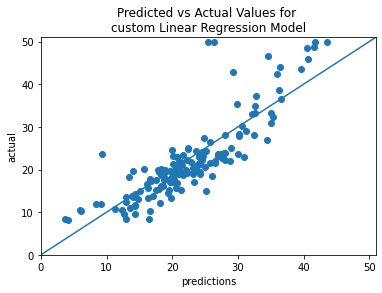

In [106]:
plt.xlabel("predictions")
plt.ylabel("actual")
plt.xlim([0,51])
plt.ylim([0,51])
plt.title("Predicted vs Actual Values for \ncustom Linear Regression Model")
plt.plot([0,51], [0,51])
plt.scatter(preds, y_test);

In [82]:
print(np.shape(X_test))
print(np.shape(X_test[:,:-1]))

(152, 13)
(152, 12)
